# NLP - Traitement Automatique du Langage Naturel

Notre librarie de code préférée pour le traitement du langage naturel est [SpaCy](https://github.com/explosion/spaCy), et nous lui avons d'ailleurs dédié un [bloc-note Jupyter](../tools/spacy.ipynb) qui démontre les bases. Le présent bloc-note utilise [NLTK](https://github.com/nltk/nltk) afin d'en souligner toutes les limitations dans le contexte de la langue française.

Les [transformers](https://arxiv.org/abs/1706.03762) ont changé les paradigmes du traitement du langage naturel. Il existe de nombreux modèles anglais et multilingues, mais peu de modèles français, l'inconvénient des modèles multilingues étant principalement leur taille, et accessoirement les faiblesses de la part du corpus d'entrainement dédiée au français. Nous avons donc souhaité rendre ici hommage aux rares modèles dédiés au français, que sont [Camembert](https://huggingface.co/almanach), [Croissant](https://huggingface.co/croissantllm), [Flaubert](https://huggingface.co/flaubert), [Vigogne](https://huggingface.co/bofenghuang), et bientôt Lucie.

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/algorithms/nlp-basics.ipynb)

In [22]:
import os
import sys

# Supprimer les commentaires pour installer (requirements.txt)
# !pip3 install -q -U beautifulsoup4
# !pip3 install -q -U matplotlib
# !pip3 install -q -U torch
# !pip3 install -q -U transformers

# À installer dans tous les cas pour Google Colab et Github
if 'google.colab' in sys.modules or 'CI' in os.environ:
    !pip3 install -q -U gensim
    !pip3 install -q -U nltk
    !pip3 install -q -U stanza
    !pip3 install -q -U wordcloud

In [23]:
# Les variables python sont accessibles depuis les commandes shell
work_directory = './nlp-basics'

!mkdir -p $work_directory

## NLTK

Nous préférons [SpaCy](../tools/spacy.ipynb) à NLTK en français, mais c'est ici l'occasion d'en faire une rapide démonstration et d'en soulever les limitations.

In [24]:
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from nltk.tag import StanfordPOSTagger
from nltk.corpus import stopwords

from gensim.models import KeyedVectors

nltk.download('punkt_tab') # pour la tokenisation en français (voir https://github.com/nltk/nltk/issues/3293)
nltk.download('stopwords') # pour les stopwords

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jlchereau/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jlchereau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
language = 'french'
text = 'Les deux petites chiennes courent après la balle.'

### Tokenisation

La tokenisation consiste à découper un texte en unités plus petites, appelées tokens, qui peuvent ensuite être traitées par des modèles d'apprentissage automatique de traitement du langage naturel.

In [26]:
doc = word_tokenize(text, language=language)
for word in doc:
    print(word)

Les
deux
petites
chiennes
courent
après
la
balle
.


### Lemmatisation

La lemmatisation consiste à réduire un mot à sa forme de base, appelée “lemme”. Contrairement à la stemmatisation qui produit une racine cardinale, le lemme est généralement un mot du dictionnaire qui représente le mot commun d'origine. Par exemple, le lemme de l'adjectif “petite” est “petit”.

Pour la langue française, il n'est pas possible d'utiliser `nltk.stem.WordNetLemmatizer`:
- [TextBlob](https://github.com/sloria/TextBlob), fondé sur NLTK, utilise [Pattern](https://pypi.org/project/Pattern/) pour la lemmatisation mais Pattern n'est [pas compatible avec les versions de scipy v1.13.0 et suivantes](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-gensim), et n'est apparemment [plus maintenu](https://stackoverflow.com/a/67544967).
- [Gensim](https://github.com/piskvorky/gensim) utilisé ci-dessous n'offre pas de fonction de lemmatisation, et nous démontrons [dans un autre bloc-note l'usage de Spacy](../tools/spacy.ipynb).
- Nous proposons donc d'utiliser [Stanza](https://github.com/stanfordnlp/stanza), la librairie fondée sur [Stanford Core NLP](https://stanfordnlp.github.io/).

In [27]:
# Stematisation avec NLTK
stemmer = FrenchStemmer()
for word in doc:
    print(word, '->', stemmer.stem(word))

Les -> le
deux -> deux
petites -> petit
chiennes -> chien
courent -> courent
après -> apres
la -> la
balle -> ball
. -> .


In [28]:
# Lemmatisation
import stanza

nlp = stanza.Pipeline(lang='fr', processors='tokenize,mwt,pos,lemma')
stanza_doc = nlp(text)
for sentence in stanza_doc.sentences:
    for word in sentence.words:
        print(word.text, '->', word.lemma)

2024-10-22 13:11:46 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-22 13:11:46 INFO: Downloaded file to /Users/jlchereau/stanza_resources/resources.json
2024-10-22 13:11:47 INFO: Loading these models for language: fr (French):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-10-22 13:11:47 INFO: Using device: cpu
2024-10-22 13:11:47 INFO: Loading: tokenize
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

Les -> le
deux -> deux
petites -> petit
chiennes -> chienne
courent -> courir
après -> après
la -> le
balle -> balle
. -> .


### Étiquetage grammatical

Le Part-of-Speech Tagging (ou étiquetage grammatical en français) essaye d’attribuer une étiquette à chaque mot d’une phrase représentant la classe grammaticale de ce mot (nom propre, adjectif, verbe, etc).

Pour la langue française, il n'est pas possible d'utiliser `nltk.pos_tag`. NLTK recommande d'utiliser `nltk.tag.StanfordPOSTagger` qui est un pont vers la librairie Java de [Stanford Core NLP](https://stanfordnlp.github.io/CoreNLP/). Nous le démontrons ci-dessous mais autant utiliser [Stanza](https://github.com/stanfordnlp/stanza), comme ci-dessus.

In [29]:
# Récupération des données (notamment pour Google Colab)
!curl --create-dirs -O --output-dir $work_directory "https://downloads.cs.stanford.edu/nlp/software/stanford-tagger-4.2.0.zip"

# Décompression du fichier
# La commande tar ne permet pas de dézipper sur Google Colab, contrairement à MacOS et Windows
# !tar -xvf $work_directory/stanford-tagger-4.2.0.zip -C $work_directory
from zipfile import ZipFile
with ZipFile(f'{work_directory}/stanford-tagger-4.2.0.zip', 'r') as ZipObj:
  ZipObj.extractall(work_directory)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.4M  100 74.4M    0     0  5963k      0  0:00:12  0:00:12 --:--:-- 5218k:10  0:00:04  0:00:06 7192k


In [31]:
# Ceci suppose que Java ait été installé et que la variable d'environnement JAVA_HOME ait été définie
# https://nlp.stanford.edu/software/tagger.shtml
jar = f'{work_directory}/stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar'
model = f'{work_directory}/stanford-postagger-full-2020-11-17/models/french-ud.tagger'
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')
tags = pos_tagger.tag(doc)
for tag in tags:
  print(tag[0], '->', tag[1])

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.




OSError: Java command failed : ['/usr/bin/java', '-mx1000m', '-cp', './nlp-basics/stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar', 'edu.stanford.nlp.tagger.maxent.MaxentTagger', '-model', './nlp-basics/stanford-postagger-full-2020-11-17/models/french-ud.tagger', '-textFile', '/var/folders/wc/l9y803l95kzbyc5wb7_4wnmw0000gn/T/tmpt9ber8fl', '-tokenize', 'false', '-outputFormatOptions', 'keepEmptySentences', '-encoding', 'utf8']

### Stop words

Les stop words sont un ensemble de mots couramment utilisés qui n’apportent pas d’information pour comprendre le sens du texte, comme le, la, un, une, etc. En traitement du langage natural, on cherche souvent à les éliminer pour se concentrer sur les mots riches de sens.

In [32]:
STOP_WORDS = stopwords.words('french')

meaningful_words = []
for word in doc:
    if word not in STOP_WORDS:
        meaningful_words.append(word)
meaningful_words

['Les', 'deux', 'petites', 'chiennes', 'courent', 'après', 'balle', '.']

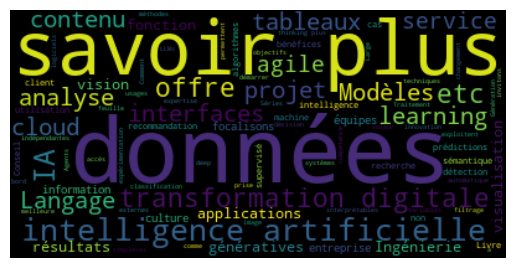

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from urllib.request import urlopen

with urlopen('https://www.digillia.com') as response:
    soup = BeautifulSoup(response, 'html.parser')
    STOP_WORDS.extend(['d', 'l', 'Digillia'])
    wc = WordCloud(stopwords = STOP_WORDS, collocations=True).generate(soup.get_text())
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Plongement lexical

Le Word Embedding (ou plongement lexical en français) est une méthode d'encodage qui vise à représenter les mots ou les phrases d’un texte par des vecteurs de nombres réels pour localiser ces mots dans un espace multi-dimensionnel (ou Vector Space Model), notamment à des fins de comparaison.

In [ ]:
# Récupération des fichiers Word2Vec pré-entraînés (notamment pour Google Colab et Github)
# Les deux premiers sont très gros et très lents à charger
# !curl --create-dirs -O --output-dir $work_directory "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz"
# !curl --create-dirs -O --output-dir $work_directory "http://wikipedia2vec.s3.amazonaws.com/models/de/2018-04-20/dewiki_20180420_100d.txt.bz2"
!curl --create-dirs -O --output-dir $work_directory "https://embeddings.net/embeddings/frWiki_no_phrase_no_postag_500_cbow_cut10.bin"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  128M  100  128M    0     0  9365k      0  0:00:14  0:00:14 --:--:-- 9589k


In [ ]:
# Chemin vers le fichier de modèle Word2Vec pré-entraîné en français
# model_path = f'{work_directory}/fasttext_embeddings_fr.vec.gz'
# model_path = f'{work_directory}/2018-04-20/dewiki_20180420_100d.txt.bz2'
# binary = False
# Le fichier ci-dessous est binaire contrairement aux deux premiers
model_path = f'{work_directory}/frWiki_no_phrase_no_postag_500_cbow_cut10.bin'
binary = True

# Charger le modèle Word2Vec pré-entraîné en français
model = KeyedVectors.load_word2vec_format(model_path, binary=binary)

# Afficher le vecteur pour un mot spécifique
word = meaningful_words[1]
print(word, '->', model[word])

deux -> [-1.43188223e-01 -1.55123323e-01 -1.76652208e-01  5.67114651e-01
  9.07518193e-02  2.28723213e-01  2.31655151e-01 -2.32938692e-01
 -2.53074430e-02  1.54531166e-01 -3.96100469e-02  1.26164243e-01
  6.94181323e-02  5.24218380e-01  3.10593098e-01  2.57824630e-01
 -4.10055935e-01 -1.20233342e-01 -4.35307235e-01 -3.54416639e-01
  4.24476385e-01 -2.91272223e-01 -3.28398615e-01  2.85763472e-01
  1.05614260e-01 -3.42503577e-01  1.49135128e-01 -4.43803817e-01
  1.32804051e-01 -2.07508102e-01 -9.21434015e-02 -1.36090532e-01
  1.18885562e-01  7.90397525e-02 -9.47980136e-02  8.97164717e-02
 -1.24256879e-01  2.32379541e-01 -1.85206234e-01  1.31950364e-01
  3.61383170e-01 -5.95386207e-01 -6.66764736e-01 -4.81542081e-01
 -4.25538830e-02  1.99623391e-01  1.41170412e-01  5.74456826e-02
  2.57270038e-02  1.19005106e-01 -1.62516043e-01  6.79081902e-02
  1.58047993e-02  1.71319157e-01  3.36675867e-02 -2.08640471e-01
  1.69163570e-01  2.97450304e-01  3.39881241e-01  3.18871677e-01
 -2.53713310e-01 

### Similarités

La représentation en vecteurs permet de mesurer la similarité par cosinus.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

word1 = 'chien'
word2 = 'cheval'
word3 = 'voiture'
word4 = 'automobile'

print(word1, word2, model.similarity(word1, word2))
print(word3, word4, model.similarity(word3, word4))
print(word1, word3, model.similarity(word1, word3))

chien cheval 0.31312007
voiture automobile 0.48476118
chien voiture 0.030805126


In [ ]:
# Ménage
!rm -rf $work_directory